In [1]:
from astropy.table import QTable, Table, Column
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.aperture import SkyEllipticalAperture
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.wcs import WCS
from matplotlib.colors import SymLogNorm
from pylab import figure, cm
from astropy import visualization
from photutils.aperture import aperture_photometry
import numpy as np
from radio_beam import Beam
from scipy.integrate import quad
from astropy.table import vstack
import seaborn as sns
plt.rcParams.update({'font.size': 14})
import astropy.units as u
from astropy import constants as c

In [2]:
base = '/orange/adamginsburg/sgrb2/NB/catalog/'
lowres = Table.read(base+'lowres_cat.txt', format='ipac')
lowres = lowres[lowres['sum']!=0]
lowres_noHII = lowres[np.where(lowres['SIMBAD_OTYPE']!='HII')]
lowres_noHII = lowres_noHII[np.where(lowres_noHII['SIMBAD_OTYPE']!='maser')]

In [7]:
base = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'
path_N = base+'sgr_b2.N.B3.cont.r0.5.1m0.075mJy.cal2.image.tt0.pbcor.fits'
path_M = base+'sgr_b2.M.B3.cont.r0.5.1m0.125mJy.cal3.image.tt0.pbcor.fits'
path_lr = base+'SgrB2_selfcal_full_TCTE7m_selfcal6_ampphase_taylorterms_multiscale_deeper_mask1.5mJy.image.tt0.pbcor.fits'

hdu_N = fits.open(path_N)[0]
hdu_M = fits.open(path_M)[0]
hdu_lr = fits.open(path_lr)[0]

In [8]:
data_N = u.Quantity(hdu_N.data, unit=hdu_N.header['BUNIT'])
data_M = u.Quantity(hdu_M.data, unit=hdu_M.header['BUNIT'])
wcs_N = WCS(hdu_N.header)
wcs_M = WCS(hdu_M.header)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [9]:
size = np.array(data_N.shape)
im_center = size/2
middle_row = data_N[int(im_center[1])]
diameter = len(middle_row[~np.isnan(middle_row)])
radius = diameter / 2

In [10]:
rows, cols = size
arr_radii = [[0 for i in range(cols)] for j in range(rows)]
arr_radii = np.array(arr_radii)
for i in range(len(arr_radii)):
    for j in range(len(arr_radii)):
        arr_radii[i][j] = ((len(data_N)/2 - i) ** 2 + (len(data_N)/2 - j) ** 2)**(1/2)

In [11]:
percent_excl = 10
radius_pixels_include = int(radius/100*(100-percent_excl))
percent_excl_c = 0
radius_pixels_include_c = int(radius/100*(percent_excl_c))
mask = [(arr_radii > radius_pixels_include) | (arr_radii < radius_pixels_include_c)]
mask = mask[0]

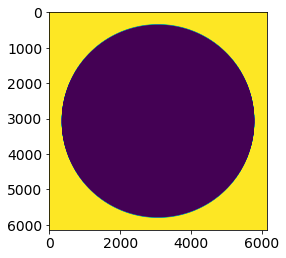

In [12]:
plt.imshow(mask)

In [13]:
all_positions = SkyCoord(lowres['RA'],lowres['Dec'], unit='deg', frame='fk5')
fctr = 1/(8*np.log(2))
Bmaj_lr = hdu_lr.header['BMAJ']*u.deg*np.sqrt(fctr)
Bmin_lr = hdu_lr.header['BMIN']*u.deg*np.sqrt(fctr)
aper = SkyEllipticalAperture(all_positions, Bmaj_lr, Bmin_lr, hdu_lr.header['BPA']*u.deg)

In [16]:
Bmaj_N = hdu_N.header['BMAJ']*u.deg*np.sqrt(fctr)
Bmin_N = hdu_N.header['BMIN']*u.deg*np.sqrt(fctr)
pix_maj_N= Bmaj_N/(hdu_N.header['CDELT2']*u.deg)
pix_min_N= Bmin_N/(hdu_N.header['CDELT2']*u.deg)
ppb_N = 2*np.pi*pix_maj_N*pix_min_N

Bmaj_M = hdu_M.header['BMAJ']*u.deg*np.sqrt(fctr)
Bmin_M = hdu_M.header['BMIN']*u.deg*np.sqrt(fctr)
pix_maj_M = Bmaj_M/(hdu_M.header['CDELT2']*u.deg)
pix_min_M = Bmin_M/(hdu_M.header['CDELT2']*u.deg)
ppb_M = 2*np.pi*pix_maj_M*pix_min_M

In [18]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

fwhm = np.sqrt(8*np.log(2))
angle = fwhm*np.sqrt(fctr)
ap_cor = quad(gaussian, -np.inf, np.inf)[0]/quad(gaussian, -angle,angle)[0]

In [19]:
phot_table_N = aperture_photometry(data_N, aper, wcs=wcs_N, mask = mask)
phot_table_M = aperture_photometry(data_M, aper, wcs=wcs_M, mask = mask) 

In [20]:
ap_cor

1.4647947734915436

In [21]:
phot_N = phot_table_N['aperture_sum'].value*ap_cor/ppb_N
phot_M = phot_table_M['aperture_sum'].value*ap_cor/ppb_M

In [23]:
hires_rms = 0.0003/4

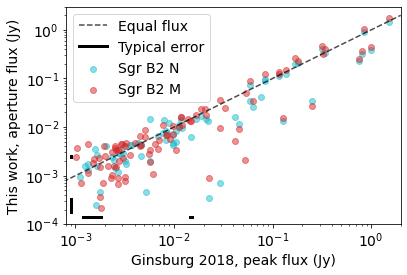

In [24]:
fig = plt.figure()#figsize=(12,12))
plt.scatter(lowres['peak']*0.92,phot_N,label='Sgr B2 N', alpha = 0.5, color = 'tab:cyan')
plt.scatter(lowres['peak']*0.92,phot_M,label='Sgr B2 M', alpha = 0.5, color = 'tab:red')
plt.plot([0,2],[0,2],label='Equal flux',color='k', linestyle = '--', alpha = 0.7)
#plt.plot([0.0001,2],[0.0001+0.00005,2+1.0],label='+50%',color='k', linestyle = ':', alpha = 0.7)
#plt.plot([0.0001,2],[0.0001-0.00005,2-1.0],label='-50%',color='k', linestyle = ':', alpha = 0.7)

G18y = 0.00014
plt.plot([0.0015-0.0003,0.0015+0.0003],[G18y,G18y], color = 'k', linewidth = 3)
plt.plot([0.015-0.0003,0.015+0.0003],[G18y,G18y], color = 'k', linewidth = 3)
plt.plot([0.015-0.0003,0.015+0.0003],[G18y,G18y], color = 'k', linewidth = 3)

plt.plot([0.0009,0.0009], [0.00025-hires_rms,0.00025+hires_rms], color = 'k', linewidth = 3)
plt.plot([0.0009,0.0009], [0.0025-hires_rms,0.0025+hires_rms], color = 'k', linewidth = 3, label = 'Typical error')


plt.loglog()
plt.xlim(0.0008,2)
plt.ylim(0.0001,3)
plt.ylabel('This work, aperture flux (Jy)')
plt.xlabel('Ginsburg 2018, peak flux (Jy)')
plt.legend()
#plt.savefig('G2018vsMine_flux.png',dpi=300,bbox_inches='tight')

Text(0.5, 0, 'Recovered flux, [high res / low res]')

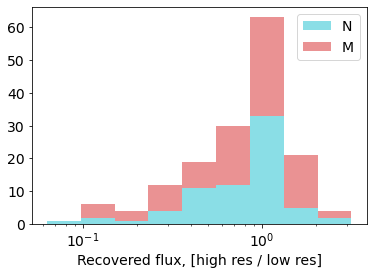

In [25]:
bins=np.logspace(-1.2,0.5,10)
plt.hist((phot_N.value/(lowres['peak']*0.92).value,phot_M.value/(lowres['peak']*0.92).value), bins=bins, stacked = True, label = ['N','M'], color = ['tab:cyan','tab:red'], alpha =0.5)
plt.legend()
plt.xscale('log')
plt.xlabel('Recovered flux, [high res / low res]')
#plt.savefig('G2018vsMine_flux_hist.png',dpi=300,bbox_inches='tight')

Text(0.5, 0, 'Recovered flux, [high res / low res]')

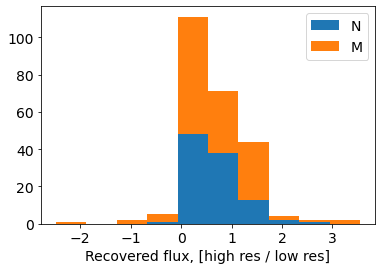

In [26]:
plt.hist((phot_N.value/(lowres['peak']*0.92).value,phot_M.value/(lowres['peak']*0.92).value), stacked = True, label = ['N','M'])
plt.legend()
plt.xlabel('Recovered flux, [high res / low res]')

In [27]:
B3freq = 92.45* u.GHz
B3_old_freq = 96.36 * u.GHz

In [28]:
SI = 2
B3_over_B3_old_flux = np.e**(SI * np.log(B3freq/B3_old_freq))
B3_over_B3_old_flux

<Quantity 0.92049249>

In [29]:
SI = np.linspace(-1,3.5)
B3_over_B3_old_flux = np.e**(SI * np.log(B3freq/B3_old_freq))

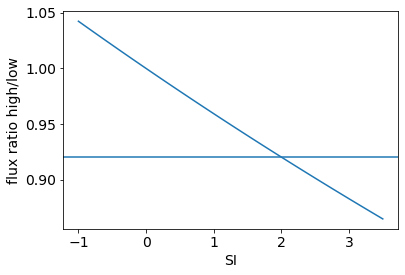

In [30]:
plt.plot(SI, B3_over_B3_old_flux)
plt.xlabel('SI')
plt.ylabel('flux ratio high/low')
plt.axhline(0.92049249)

In [31]:
np.min(B3_over_B3_old_flux)

<Quantity 0.8650385>

In [32]:
np.max(B3_over_B3_old_flux)

<Quantity 1.04229313>

In [33]:
catNB3 = Table.read(base+'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB3 = Table.read(base+'catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catNB6 = Table.read(base+'catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB6 = Table.read(base+'catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
from purify_catalog import cat_purification
catNB3_c, catNB3_m, catNB3_r = cat_purification(catNB3)
catMB3_c, catMB3_m, catMB3_r = cat_purification(catMB3)
catNB6_c, catNB6_m, catNB6_r = cat_purification(catNB6)
catMB6_c, catMB6_m, catMB6_r = cat_purification(catMB6)

catB3_m = vstack([catNB3_m, catMB3_m])
catB6_m = vstack([catNB6_m, catMB6_m])

Removed 198 sources for the complete catalog
Removed 9 sources for the medium catalog
Removed 81 sources for the robust catalog
Removed 186 sources for the complete catalog
Removed 7 sources for the medium catalog
Removed 47 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 6 sources for the medium catalog
Removed 58 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 8 sources for the medium catalog
Removed 32 sources for the robust catalog


In [34]:
base = '/orange/adamginsburg/sgrb2/NB/the_end/'
pathNB3 = base+'sgr_b2.N.B3.cont.r0.5.1m0.075mJy.cal2.image.tt0.pbcor.fits'
pathMB3 = base+'sgr_b2.M.B3.cont.r0.5.1m0.125mJy.cal3.image.tt0.pbcor.fits'
pathNB6 = base+'sgr_b2.N.B6.cont.r0.5.1m1.5mJy.cal4.image.tt0.pbcor.fits'
pathMB6 = base+'sgr_b2.M.B6.cont.r0.5.1m0.68mJy.cal3.image.tt0.pbcor.fits'

In [35]:
def read_in(path):
    """
    Simplify reading in the files.
    """
    fh=fits.open(path)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        wcs = WCS(fh[0].header)
        hdr = fh[0].header
    datas=fh[0].data #
    return datas, wcs, hdr

In [36]:
import warnings

In [37]:
# read in the data, wcs, and the header
dataNB3, wcsNB3, hdrNB3 = read_in(pathNB3)
dataMB3, wcsMB3, hdrMB3 = read_in(pathMB3)
dataNB6, wcsNB6, hdrNB6 = read_in(pathNB6)
dataMB6, wcsMB6, hdrMB6 = read_in(pathMB6)
# get the beam from the header
my_beamNB3 = Beam.from_fits_header(hdrNB3)
my_beamMB3 = Beam.from_fits_header(hdrMB3)
my_beamNB6 = Beam.from_fits_header(hdrNB6)
my_beamMB6 = Beam.from_fits_header(hdrMB6)

In [38]:
B3freq = 92.45* u.GHz
B6freq = 225.78 * u.GHz

In [39]:
equivB3 = u.brightness_temperature(B3freq)
equivB6 = u.brightness_temperature(B6freq)
beam_area_NB3 = my_beamNB3.sr
beam_area_MB3 = my_beamMB3.sr
beam_area_NB6 = my_beamNB6.sr
beam_area_MB6 = my_beamMB6.sr

In [41]:
T_B_NB3 = (catNB3_m['peak']*u.beam/beam_area_NB3).to(u.K, equivalencies=equivB3)
T_B_MB3 = (catMB3_m['peak']*u.beam/beam_area_MB3).to(u.K, equivalencies=equivB3)
T_B_B3_peak = np.concatenate([T_B_NB3, T_B_MB3]).value
T_B_NB6 = (catNB6_m['peak']*u.beam/beam_area_NB6).to(u.K, equivalencies=equivB6)
T_B_MB6 = (catMB6_m['peak']*u.beam/beam_area_MB6).to(u.K, equivalencies=equivB6)
T_B_B6_peak = np.concatenate([T_B_NB6, T_B_MB6]).value

In [44]:
T_B_NB3 = (catNB3_m['flux']/((catNB3_m['area_exact']/beam_area_NB3).to(u.dimensionless_unscaled))/beam_area_NB3).to(u.K, equivalencies=equivB3)
T_B_MB3 = (catMB3_m['flux']/((catMB3_m['area_exact']/beam_area_MB3).to(u.dimensionless_unscaled))/beam_area_MB3).to(u.K, equivalencies=equivB3)
T_B_NB6 = (catNB6_m['flux']/((catNB6_m['area_exact']/beam_area_NB6).to(u.dimensionless_unscaled))/beam_area_NB6).to(u.K, equivalencies=equivB6)
T_B_MB6 = (catMB6_m['flux']/((catMB6_m['area_exact']/beam_area_MB6).to(u.dimensionless_unscaled))/beam_area_MB6).to(u.K, equivalencies=equivB6)
T_B_B3_flux = np.concatenate([T_B_NB3, T_B_MB3]).value
T_B_B6_flux = np.concatenate([T_B_NB6, T_B_MB6]).value

(-2.0, 102.0)

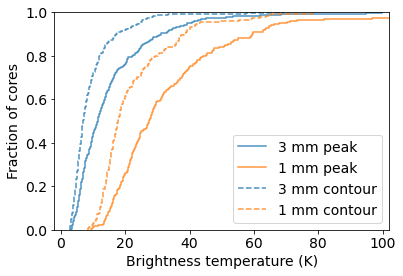

In [46]:
sns.ecdfplot(T_B_B3_peak, label = '3 mm peak', alpha = 0.8)
sns.ecdfplot(T_B_B6_peak, label = '1 mm peak', alpha = 0.8)

sns.ecdfplot(T_B_B3_flux, label = '3 mm contour', alpha = 0.8, color = 'tab:blue', linestyle = '--')
sns.ecdfplot(T_B_B6_flux, label = '1 mm contour', alpha = 0.8, color = 'tab:orange', linestyle = '--')
plt.legend()
plt.xlabel('Brightness temperature (K)')
plt.ylabel('Fraction of cores')
#plt.xscale('log')
plt.xlim(-2,102)
#plt.savefig('brightness_T.png',dpi=300,bbox_inches='tight')

In [49]:
fctr = 1/(8*np.log(2))

In [50]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

fwhm = np.sqrt(8*np.log(2))
angle = fwhm*np.sqrt(fctr)
ap_cor = quad(gaussian, -np.inf, np.inf)[0]/quad(gaussian, -angle,angle)[0]

In [51]:
total_flux = quad(gaussian, -np.inf, np.inf)[0]

In [54]:
gaussian(0)

1.0

In [55]:
min_value = 4 # sigma
max_value = 20 # sigma (change this)
a = min_value/max_value
crop = np.sqrt(-2*np.log(a))

true = quad(gaussian, -np.inf, np.inf)[0]
observed = quad(gaussian, -crop, crop)[0]
percent_err = (observed - true)/true * 100
percent_err

-7.2793606063632605

In [56]:
max_flux_sigma = np.linspace(5,100, 100)

In [57]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

In [ ]:
# calculating error caused by astrodendro leaf edge cropping

In [58]:
def cropping_err(max_flux_sigma):
    min_value = 4
    a = min_value/max_flux_sigma
    crop = np.sqrt(-2*np.log(a))

    true = quad(gaussian, -np.inf, np.inf)[0]
    observed = quad(gaussian, -crop, crop)[0]
    percent_err = (observed - true)/true * 100
    percent_err
    
    return percent_err

In [60]:
def gaussian(x, x0=0, width=1):
    return np.exp(-(x-x0)**2/(2*width**2))

def apperture_corr(cat):
    true = quad(gaussian, -np.inf, np.inf)[0]
    adjusted_flux_array = []
    for core in cat:
        min_value = core['ring_std'] * 4 # multiplying by 4 beacause the min_value was set to 4 sigma
        peak_flux = core['peak']
        a = min_value / peak_flux
        crop = np.sqrt(-2*np.log(a))
        ratio_true_obs = true / (quad(gaussian, -crop, crop)[0])
        
        adjusted_flux = core['flux'] * ratio_true_obs
        
        adjusted_flux_array += [adjusted_flux]
        
    return adjusted_flux_array

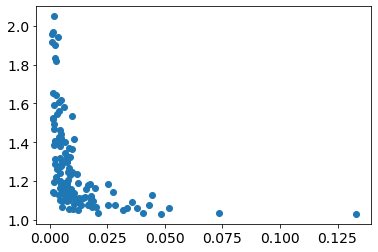

In [62]:
plt.scatter(catNB6_m['flux'], apperture_corr(catNB6_m)/catNB6_m['flux'])

In [63]:
errors = []
for flux in max_flux_sigma:
    err = cropping_err(flux)
    errors += [err]

Text(0, 0.5, '% error')

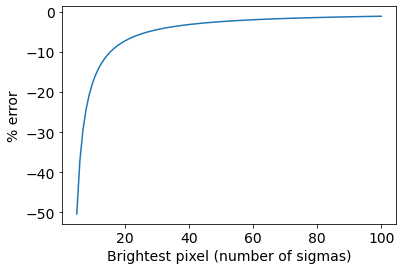

In [64]:
plt.plot(max_flux_sigma, errors)
plt.xlabel('Brightest pixel (number of sigmas)')
plt.ylabel('% error')

In [65]:
(quad(gaussian, -np.inf, np.inf)[0] - quad(gaussian, -1,1)[0])/(quad(gaussian, -np.inf, np.inf)[0]) * 100

31.731050786291387